In [1]:
%matplotlib inline
import sys
import copy
sys.path.append('../../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict, namedtuple, defaultdict
import time
#from modules.backtesting import BackTester
from modules.tools import open_file, product_info, ohlc_chart
#from factory import ohlc_chart

In [2]:
feed = open_file('h5py', 'raw data/daily_futures.h5', mode='r')

In [3]:
class Market:
    """
    시장 정보 제공
    매매신호 생성기능
    """
    
    long = Long = L = 1
    short = Short = S = -1
    commission = 3.5 #편도 수수료
    sectors = ['Currency','Grain','Meat','Tropical','Petroleum','Equity','Rate']
    
    def __init__(self, feed, signal=None):
        """
        feed: pandas dataframe 형식의 시장 기초데이터
        signal: signal 생성 함수
        """
        if not signal:
            signal = self.default_signal
        
        self.pinfo = {}
        self._preprocessing(feed, signal)
        
    def _preprocessing(self, feed, signal):
        """
        종목별로 시그널을 생성하여 feed에 merge하고
        종목별 데이터를 날짜순으로 모두 합침
        """
        header = feed.attrs['columns'].split(';') #데이터 명
        
        container = []
        pinfo = product_info()
        for (cnt,inst) in enumerate(feed.values()):
            symbol =  inst.attrs['symbol']
            if symbol == 'None' or not symbol:
                continue
            
            else:
                self.pinfo[symbol] = pinfo[symbol]
            
            datatable = pd.DataFrame(inst.value[:,1:], index=inst.value[:,0].astype('M8[s]'), columns=header[1:])
            datatable.sort_index(inplace=True)
            
            if signal:
                print(f"\r preprocessing data...({cnt})          ", end='', flush=True)
                signal(datatable)
            columns = datatable.columns.tolist()
            new_column = [[symbol for i in range(len(columns))], columns]
            datatable.columns = new_column
            container.append(datatable)
        print('\nDone')
        # warm period = 60days
        self.feed = pd.concat(container, axis=1).sort_index(axis=1).iloc[60:]
    
    @classmethod
    def price_to_value(cls, inst, price):
        """
        상품가격(차이)를 그에 해당하는 화폐단위로 변화
        """
        return price * inst['tick_value'] / inst['tick_unit']
    
    @classmethod
    def get_profit(self, inst, position, entryprice, exitprice, lot=1):
        """
        틱: (청산가격 - 진입가격)/틱단위
        손익계산: 랏수 * 틱가치 * 틱      
        """
        if np.isnan(entryprice) or np.isnan(exitprice):
            raise ValueError('Nan value can not be calculated')
        
        tick = round(position * (exitprice - entryprice)/inst['tick_unit'])
        profit = lot * inst['tick_value']* tick
        
        return profit, tick
    
    @classmethod
    def get_price(cls, pinfo, price1, price2, skid):
        """
        진입 주문시 슬리피지 계산
        """
        bound = (price2 - price1)*skid
        #price = np.random.uniform(price1, price1 + bound)
        
        price = round(price1+bound, pinfo['decimal_places'])
        
        return price
    
    
    @classmethod
    def get_lot(cls, risk, heat):
        lot = int(heat / risk)
        return lot
    
    @classmethod
    def set_ATR(cls, metrics, span=20):
            df = pd.DataFrame()
            df['hl'] = metrics['high'] - metrics['low']
            df['hc'] = np.abs(metrics['high'] - metrics['close'].shift(1))
            df['lc'] = np.abs(metrics['low'] - metrics['close'].shift(1))
            df['TR'] = df.max(axis=1)
            metrics['ATR'] = df['TR'].ewm(span).mean()
    
    @staticmethod
    def default_signal(datatable):
        """
        시장 기초데이터로부터 MA, trend index등을 생성하는 
        data preprocessing method이다.
        
        datatable: 종목별 ohlc 데이터를 저장한 pandas dataframe
        gc: 20일 지수이평과 60일 지수이평의 교차신호
        atr: 20일 atr
        
        """
        Market.set_ATR(datatable, span=20)
        
        ema20 = datatable['close'].ewm(20).mean()
        ema60 = datatable['close'].ewm(60).mean()
        
        datatable['golden'] = (ema20>ema60).astype('int').diff().shift(1)
        datatable.dropna(inplace=True)

In [4]:
market=Market(feed=feed)

 preprocessing data...(63)          
Done


In [5]:
class Trade:
    
    def __init__(self):
        self.open_trades = [] #진행중인 매매
        self._log = [] #종료된 매매기록
        self.entryid = 0
    
        
    def open(self, inst, strategy, position, entrydate,
             entryprice, entrylot, stopprice, risk):
        
        self.entryid += 1
        trade = {
            'id': self.entryid,
            'symbol': inst['symbol'],
            'name': inst['name'],
            'sector': inst['sector'],
            'inst': inst,
            'strat': strategy,
            'position': position,
            'entrydate': entrydate,
            'entryprice': entryprice,
            'entrylot': entrylot,
            'stopprice': stopprice,
            'openlot': entrylot,
            'risk': risk
        }
        self.open_trades.append(trade)
    
    
    def close(self, trade, exitdate, exitprice, force):
        
        trade['exitdate'] = exitdate
        trade['exitprice'] = exitprice
        trade['exitlot'] = trade['entrylot']
        trade['force'] = force
        
        profit, tick = Market.get_profit(trade['inst'], trade['position'], trade['entryprice'],
                                   trade['exitprice'], lot=trade['exitlot'])
        
        trade['profit'] = profit
        trade['tick'] = tick
        
        self._log.append(trade)
        self.open_trades.remove(trade)
        return trade
        
    
    def get(self, inst, strategy, position):
        symbol = inst['symbol']
        trade = list(filter(lambda x: x['symbol']==symbol\
                     and x['position']==position\
                     and x['strat']==strategy, self.open_trades))
        if trade:
            return trade[0]
        else:
            return None
        
    def get_sector(self, sector):
        trades = list(filter(lambda x: x['inst']['sector'] == sector, self.open_trades))
        return trades
        
    def isopen(self, inst, strategy, position):
        symbol = inst['symbol']
        trade = self.get(inst, strategy, position)
        if trade:
            return True
        else:
            return False
    
    def count(self):
        return len(self.open_trades)
    

In [10]:
class Trader:
    """
    트레이더 봇
    매매전략 
    매매기록
    매매분석
    """
    def __init__(self, market, principal, portfolio_heat, sector_heat, heat, 
                 strategy=None, stop=None, max_lot=None):
        # 시장 정보 설정
        #self.feed = market.feed.copy(deep=True)
        self.market = market
        self.pinfo = copy.deepcopy(market.pinfo)
        self.trades = Trade()
        
        if strategy:
            Trader.strategy = strategy
        else:
            Trader.strategy = Trader.default_strategy
    
        if stop:
            Trader.stop = stop
        else:
            Trader.stop = Trader.default_stop
        
        """
        * 자산 초기값 설정 *
        principal: 투자원금
        capital: 순자산
        equity: 순자산 + 평가손익 (평가자산)
        real_equity: 순자산 + 청산예정손익 (실질자산)
        avail_equity: equity - 증거금 (가용자산)
        cum_commision: 누적 수수료
        """
        self.principal = principal
        self.capital = principal
        self.equity = principal
        self.avail_equity = principal
        self.real_equity = principal
        self.cum_commission = 0 #누적 수수료
        self.maxlot = max_lot
        
        """
        * 리스크 *
        portfolio_heat: real_equity 대비 허용가능 포트폴리오 손실액
        heat: real_equity 대비 허용가능 매매 손실액
        """
        self._portfolio_heat = portfolio_heat
        self._heat = heat
        self._sector_heat = sector_heat
        
        #매매관련 정보
        self._equitylog = [] #자산 기록
        self._rejected_order = [] #진입 거부된 매매
    
    @property
    def equitylog(self):
        columns = ['date', 'capital','open profit','equity','real equity',
                   'port risk', 'port heat', 'fee', '#']
        return pd.DataFrame(self._equitylog, columns=columns).set_index('date')
    
    @property
    def tradelog(self):
        df = pd.DataFrame(self.trades._log)
        df = df[['id','sector','symbol','name','position','entrydate','entryprice','stopprice','entrylot',
                 'exitdate','exitprice','exitlot','force','risk','profit','tick','strat']].copy(deep=True)
        df['position'] = np.where(df['position']==Market.long, 'Long','Short')
        
        return df
    
    @property
    def rejected(self):
        columns = ['#','name','date','real equity', 'risk','heat',
                   'sector risk', 'sector heat','port risk', 'port heat','strategy','type']
        
        return pd.DataFrame(self._rejected_order, columns=columns)
    
    def view(self, logname, df):
        if logname == 'tradelog':
            return df.style.format({
                    'entryprice': "{:,.6g}",
                    'stopprice': "{:,.6g}",
                    'exitprice': "{:.6g}",
                    'risk': "{:.0f}",
                    'profit': "{:.0f}",
                })
        
        if logname == 'rejected':
            return self.rejected.syle.format({
                    'real equity': "{:,.1f}",
                    'risk': "{:,.1f}",
                    'heat': "{:.1f}",
                    'sector risk': "{:.1f}",
                    'sector heat': "{:.1f}",
                    'port risk': "{:.1f}",
                    'port heat': "{:.1f}",
            })
    
    
    @property
    def heat(self):
        """
        실질자산 대비 허용가능 매매 손실액
        """
        return self._heat * self.capital
    
    @property
    def sector_heat(self):
        """
        섹터별 허용가능 손실액
        """
        return self._sector_heat * self.capital
    
    @property
    def portfolio_heat(self):
        """
        투자자산 대비 허용가능 포트 손실액
        """
        return self._portfolio_heat * self.capital
    
    @property
    def portfolio_risk(self):
        """
        포트폴리오 리스크: 
        """
        risk = self.capital - self.real_equity
        return risk if risk > 0 else 0
        #return sum(trade['risk'] for trade in self.trades.open_trades)
        
    def sector_risk(self, inst):
        trades = self.trades.get_sector(inst['sector'])
        risk = 0
        for trade in trades:
            if ('stop_profit' in trade) and trade['stop_profit']:
                risk += trade['stop_profit']
            else:
                risk += trade['risk']
        
        return risk
        
    def get_risk(self, inst, position, entryprice, stopprice, lot=1):
        """
        리스크 = (진입가 - 스탑가격) * 가격유닛 * 랏수
        """
        pricediff = position * (entryprice - stopprice)
        if pricediff < 0:
            raise ValueError("trade risk cannot be negative")
        else:
            risk_per_lot = Market.price_to_value(inst, pricediff)
            return risk_per_lot * lot
    
    def run_trade(self, start=None, end=None):
        #symbols = self.feed.columns.remove_un levels[0] #종목 코드
        self.feed = self.market.feed.loc[start:end].copy(deep=True)
        self.feed.columns = self.feed.columns.remove_unused_levels()
        symbols = self.feed.columns.levels[0]
        
        for date, metrics in self.feed.iterrows():
            print("\r now trading at %s         "%date, end='', flush=True)
            self.commission = 0
            
            for symbol in symbols:
                metric = metrics[symbol]
                inst = self.pinfo[symbol]
                if not metric.hasnans:
                    self.strategy(inst, metric)
                
            # 강제청산 모니터링 및 매매기록
            self.force_stop(metrics)
            self.write_equitylog(metrics)
            if self.equity < 0:
                print("\nYou went bankrupt!")
                break
                
    
    def buy(self, inst, strat, position, entrydate, entryprice, stopprice):
        
        # 기준값
        heat = self.heat
        sector_heat = self.sector_heat
        sector_risk = self.sector_risk(inst)
        port_heat = self.portfolio_heat
        port_risk = self.portfolio_risk
        num_trades = self.trades.count()

        # 랏당 리스크 계산
        risk_per_lot = self.get_risk(inst, position, entryprice, stopprice, lot=1)
        
        
        #랏당 리스크가 기준치 초과하면 매매거부
        if risk_per_lot > heat:
            self._rejected_order.append( [num_trades, inst['name'], entrydate, self.real_equity, risk_per_lot, heat,
                                 sector_risk, sector_heat, port_risk, port_heat, strat, 1])
        
        
        elif risk_per_lot > sector_heat - sector_risk:
            self._rejected_order.append( [num_trades, inst['name'], entrydate, self.real_equity, risk_per_lot, heat,
                                 sector_risk, sector_heat, port_risk, port_heat, strat, 2])
        
        
        elif risk_per_lot > port_heat - port_risk:
            self._rejected_order.append( [num_trades, inst['name'], entrydate, self.real_equity, risk_per_lot, heat,
                                 sector_risk, sector_heat, port_risk, port_heat, strat, 3])
            
        
        
        else:
            #리스크에 맞게 랏 계산
            actual_heat = min(heat,sector_heat - sector_risk, port_heat - port_risk)
            entrylot = Market.get_lot(risk_per_lot, actual_heat)
            risk = self.get_risk(inst, position, entryprice, stopprice, lot=entrylot)
            
            #최대허용가능 랏수
            if self.maxlot and entrylot > self.maxlot:
                entrylot = self.maxlot
        
        
            #진입하려는 전략이 이미 매매중인 경우 에러
            if self.trades.isopen(inst, position, strat):
                raise AttributeError(f"open entry for '{inst['name']}' on '{position}' already exist!")
            
            #가격이 이상한 경우 에러
            if np.isnan(entryprice) or np.isnan(stopprice):
                raise ValueError(f"Price can not be NaN value")
                    
            else:
                self.trades.open(
                    inst=inst,
                    strategy=strat,
                    position=position,
                    entrydate=entrydate,
                    entryprice=entryprice,
                    entrylot=entrylot,
                    stopprice=stopprice,
                    risk=risk
                )
                self.commission += (entrylot * Market.commission)
            

    def sell(self, trade, exitdate, exitprice, force=False):

        #trade = self.trades.get(inst, strat, position)
        #if trade['position']*(exitprice - trade['stopprice']) < 0:
        #    exitprice = trade['stopprice']
            
            
        log = self.trades.close(trade, exitdate, exitprice, force)
        self.commission += (log['exitlot'] * Market.commission)
        self.capital += log['profit']
        
    def force_stop(self, metrics):
        """
        강제청산: 일중가격이 스탑가격을 초과하면 스탑가격에서 청산
        """
        date = metrics.name
        
        for trade in self.trades.open_trades.copy():
            symbol = trade['symbol']
            
            if not metrics[symbol].hasnans:
                position = trade['position']
                stopprice = trade['stopprice']
                high = metrics[symbol]['high']
                low = metrics[symbol]['low']
                
                if (position == Market.long) and (stopprice > low):
                    trade['low'] = low
                    self.sell(trade, date, trade['stopprice'], force=True)
                    
                elif (position == Market.short) and (stopprice < high):
                    trade['high'] = high
                    self.sell(trade, date, trade['stopprice'], force=True)
                    
                    
    def write_equitylog(self, metrics):
        
        date = metrics.name
        open_profit, stop_profit, margin = self.update_status(metrics)
        
        self.cum_commission += self.commission
        self.capital = self.capital - self.commission
        self.equity = self.capital + open_profit
        self.real_equity = self.capital + stop_profit
        self.avail_equity = self.equity - margin
        
        self._equitylog.append([date, self.capital, open_profit, self.equity, self.real_equity,
                                self.portfolio_risk, self.portfolio_heat, self.cum_commission, self.trades.count()])
        
    def update_status(self, metrics):
        """
        1. 스탑가격 업데이트
        2. 평가손익, 청산예정손익(stop profit), 증거금 업데이트
        """
        open_profit = 0
        stop_profit = 0
        margin = 0
        
        for trade in self.trades.open_trades:
            inst = trade['inst']
            symbol = trade['symbol']
            metric = metrics[symbol]

            if not metric.hasnans:
                #stopprice update
                if self.stop:
                    stopprice = self.stop(trade, metric)
                    trade['stopprice'] = stopprice
                
                trade['open_profit'], _ = Market.get_profit(inst, trade['position'], trade['entryprice'],
                                                 metric['close'], lot=trade['openlot'])
                trade['stop_profit'], _ = Market.get_profit(inst, trade['position'], trade['entryprice'],
                                                 trade['stopprice'], lot=trade['openlot'])
                
                                                
            open_profit += trade['open_profit']
            stop_profit += trade['stop_profit']
            margin += trade['openlot'] * inst['keep_margin']
            
            if np.isnan(open_profit) or np.isnan(stop_profit):
                        raise ValueError("Profit can not be NaN value")
                    
        return open_profit, stop_profit, margin
        
        

        
    """
    결과 분석
    """
    def summary(self, level=0):
        if level == 0:
            self.equity_plot()
            return self.total_result()
        
        elif level == 1:
            return self.trade_result(level='sector')
        
        elif level == 2:
            return self.trade_result(level='name')
    
    def report(self, symbol, start=None, end=None):
        """
        종목별 매매 결과를 출력함
        """
    
        feed = self.feed[symbol].loc[start:end].dropna()
        tradelog = self.tradelog
        tradelog = tradelog[tradelog.symbol == symbol]
        
        
        if start and end:
            trade = tradelog[ (start <= tradelog.entrydate) & (tradelog.exitdate <= end)]
        else:
            trade = tradelog
        
        cumprofit = trade.profit.cumsum()
        num_trades = len(trade)
        
        fig, (ax) = plt.subplots(2,1, figsize=(15,10),
                                gridspec_kw = {'height_ratios':[3,1]})
        
        #price chart
        ax[0] = ohlc_chart(ax[0], feed, linewidth=0.8, color='black')
        for idx, row in trade.iterrows():
            y=feed.loc[row['entrydate']:row['exitdate']]
            ax[0] = ohlc_chart(ax[0], y, color='red' if row['position']=='Long' else 'blue')
       
        #tick profit chart
        ax[1].bar(np.arange(1,num_trades+1), np.where(trade.position=='Long', trade.tick, 0), 0.3, color='red', alpha=0.6 )
        ax[1].bar(np.arange(1,num_trades+1), np.where(trade.position=='Short', trade.tick, 0), 0.3, color='blue', alpha=0.6 )
           
        #labels
        name = self.pinfo[symbol]['name']
        ax[0].set_title(name, fontsize=20)
        ax[0].set_ylabel('Price', fontsize=15)
        ax[1].set_ylabel('Profit (tick)', fontsize=15)
       
        #styles
        ax[1].axhline(y=0, linewidth=1, color='darkgrey')
        ax[1].yaxis.tick_right()
        ax[1].set_facecolor('lightgoldenrodyellow')
        ax[1].set_xticks(range(1,num_trades+1))
        ax[1].grid(linestyle='--')
    
        plt.show()
        return trade.reset_index(drop=True)
    
    def trade_result(self, level='name'):
        result = []
        for level, table in self.tradelog.groupby(level):
            
            long = table[table.position == 'Long']
            longprofit = long.tick.mean()
            longperiod = (long.exitdate - table.entrydate).mean().days

            short = table[table.position == 'Short']
            shortprofit = short.tick.mean()
            shortperiod = (short.exitdate - short.entrydate).mean().days
            
            ave_num = len(table)/len(np.unique(table.symbol))
            
            trade = OrderedDict({
                #'symbol': symbol,
                'name': level,#self.pinfo[symbol]['name'],
                '총손익(틱)': table.tick.sum(),
                '평균손익(틱)': table.tick.mean(),
                '표준편차(틱)': table.tick.std(),
                '위험대비손익': (table.profit/table.risk).mean(),
                '승률': len(table[table.profit >= 0])/len(table),
                '매수평균(틱)': longprofit,
                '매도평균(틱)': shortprofit,
                'Period(L)': longperiod,
                'Period(S)': shortperiod,
                '# trades': ave_num
            })
            result.append(trade)
        df = pd.DataFrame(result)
        df.set_index('name', inplace=True)
        del df.index.name
        #styling
        df = df.style.format({
                    '평균손익(틱)': "{:.2f}",
                    '표준편차(틱)': "{:.2f}",
                    '위험대비손익': "{:.2%}",
                    '승률': "{:.2%}",
                    '매수평균(틱)': "{:.2f}",
                    '매도평균(틱)': "{:.2f}",
                    'Period(L)': "{:.0f} days",
                    'Period(S)': "{:.0f} days",
                    '# trades': "{:.1f}"
                })
        return df
    

    def total_result(self):
        trade = self.tradelog
        equitylog = self.equitylog
        realequity = equitylog['real equity']
        capital = realequity.iloc[-1]
        
        timedelta = (equitylog.index.max() - equitylog.index.min()).days/365.25
        drawdown = (realequity.cummax() - realequity)/realequity.cummax()
        mdd = drawdown.max()
        icagr = np.log(capital/self.principal) /timedelta
        bliss = icagr/mdd
        
        total = OrderedDict({
            '투자금': self.principal,
            '최종자산': capital,
            '총손익': (capital / self.principal) - 1,
            'Bliss': icagr/mdd,
            'ICAGR': icagr,
            'MDD': mdd,
            '손익비': abs(trade.profit[trade.profit >=0].sum()/trade.profit[trade.profit < 0].sum()),
            '승률': len(trade[trade.profit >= 0])/len(trade),
            '위험대비손익': (trade.profit/trade.risk).mean(),
            '평균손익': trade.profit.mean(),
            '손익표준편차': trade.profit.std(),
            '보유기간': (trade.exitdate - trade.entrydate).mean().days,
            '# trades': len(trade) / timedelta
        })
        
        trade = self.tradelog[self.tradelog.position == 'Long']
        long = OrderedDict({
            '투자금': '',
            '최종자산': '',
            '총손익': '',
            'Bliss': '',
            'ICAGR': '',
            'MDD': '',
            '손익비': abs(trade.profit[trade.profit >=0].sum()/trade.profit[trade.profit < 0].sum()),
            '승률': len(trade[trade.profit >= 0])/len(trade),
            '위험대비손익': (trade.profit/trade.risk).mean(),
            '평균손익': trade.profit.mean(),
            '손익표준편차': trade.profit.std(),
            '보유기간': (trade.exitdate - trade.entrydate).mean().days,
            '# trades': len(trade) / timedelta
        })
        
        trade = self.tradelog[self.tradelog.position == 'Short']
        short = OrderedDict({
            '투자금': '',
            '최종자산': '',
            '총손익': '',
            'Bliss': '',
            'ICAGR': '',
            'MDD': '',
            '손익비': abs(trade.profit[trade.profit >=0].sum()/trade.profit[trade.profit < 0].sum()),
            '승률': len(trade[trade.profit >= 0])/len(trade),
            '위험대비손익': (trade.profit/trade.risk).mean(),
            '평균손익': trade.profit.mean(),
            '손익표준편차': trade.profit.std(),
            '보유기간': (trade.exitdate - trade.entrydate).mean().days,
            '# trades': len(trade) / timedelta
        })
        
        #data = [[self.principal, capital, cum_profit, bliss, icagr, mdd, 
        #                 profit_factor, win_rate, max_profit, max_loss, num_trade]]
        #columns = ['투자금','최종자산','총손익','Bliss','ICAGR','MDD','손익비','승률',
        #                   '최대수익','최대손실','매매횟수(연)']
        report = pd.DataFrame([total,long,short], index=['Total','Long','Short'])
        
        report = report.style.format({
                    '투자금': lambda x: "{:,.0f}".format(x) if x else '',
                    '최종자산': lambda x: "{:,.0f}".format(x) if x else '',
                    '총손익': lambda x: "{:.2%}".format(x) if x else '',
                    'Bliss': lambda x: "{:,.3f}".format(x) if x else '',
                    'ICAGR': lambda x: "{:,.2%}".format(x) if x else '',
                    'MDD': lambda x: "{:,.2%}".format(x) if x else '',
                    '손익비': "{:.2f}",
                    '승률': "{:.2%}",
                    '위험대비손익': "{:,.2%}",
                    '평균손익': "{:,.0f}",
                    '손익표준편차': lambda x: "{:,.0f}".format(x) if x else '',
                    '보유기간': "{:,.0f} days",
                    '# trades': "{:.1f}"
                })
        
        
        return report 
    
    def equity_plot(self):
        trade = self.tradelog
        equitylog = self.equitylog
        x = equitylog.index.values
        equity = equitylog.equity.values
        capital = equitylog.capital.values
        realequity = equitylog['real equity'].values
        realequity_max = equitylog['real equity'].cummax().values
        
        fig, ax = plt.subplots(1,1, figsize=(15, 8))
        #ax.fill_between(x, realequity, facecolor='green',alpha=0.4, interpolate=True)
        ax.fill_between(x, self.principal, realequity, where=realequity>=self.principal, facecolor='green', alpha=0.4, interpolate=True, label='real equity')
        ax.fill_between(x, self.principal, realequity, where=realequity<self.principal, facecolor='red', alpha=0.6, interpolate=True)
        ax.fill_between(x, realequity, realequity_max, color='grey', alpha=0.2)
        ax.plot(x, equity, color='orange',alpha=0.7, linewidth=1, label='open equity')
        ax.plot(x, capital, color='black',alpha=0.7, linewidth=1, label='capital')
        
        ax.set_xlim([x.min(), x.max()])
        
        #labels
        ax.legend(loc='upper left', fontsize='large')
        ax.set_title('Cumulative Profit', fontsize=17)
        #ax.set_xlabel('Date', fontsize=15)
        ax.set_ylabel('equity ($)', fontsize=12)
        ax.yaxis.set_label_position("right")
       
    
        #style
        ax.grid(linestyle='--')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
        ax.yaxis.tick_right()
        fig.autofmt_xdate()
        
        plt.show()    
    
    def default_strategy(self, inst, metric):
        """
        ** default strategy: long only MA cross system **
        진입: 20종가이평이 60종가이평 돌파상승 한 다음날 시가 진입
        청산: 진입한 투자금(증거금) 대비 10% 이상 평가손실시 청산
        """
        date = metric.name
        # 상승 신호
        if metric['golden'] == 1:
            # 매수진입 매매 없으면 진입
            if not self.trades.isopen(inst, 'GC', Market.long):
                entryprice= Market.get_price(inst, metric['open'], metric['high'], skid=0.25)
                stopprice = entryprice - metric['ATR']*5
                self.buy(inst,'GC', Market.long, date, entryprice, stopprice)
            # 매도진입 매매 있으면 청산
            if self.trades.isopen(inst, 'GC', Market.short):
                trade = self.trades.get(inst, 'GC', Market.short)
                exitprice = Market.get_price(inst, metric['open'], metric['low'], skid=0.25)
                self.sell(trade, date, exitprice)
        
        if metric['golden'] == -1:
            #매도 진입 매매 없으면 매도 진입
            if not self.trades.isopen(inst, 'GC', Market.short):
                entryprice= Market.get_price(inst, metric['open'], metric['low'], skid=0.25)
                stopprice = entryprice + metric['ATR']*5
                self.buy(inst,'GC', Market.short, date, entryprice, stopprice)
        
            # 매수진입 매매 있으면 청산
            if self.trades.isopen(inst, 'GC', Market.long):
                trade = self.trades.get(inst, 'GC', Market.long)
                exitprice = Market.get_price(inst, metric['open'], metric['high'], skid=0.25)
                self.sell(trade, date, exitprice)
                
    def default_stop(self, trade, metric):
        return trade['stopprice']

In [7]:
def stop(trader, trade, metric):
    """
    open_profit, _ = Market.get_profit(trade['inst'], trade['position'], trade['entryprice'], metric['close'], lot=trade['openlot'])
    
    if open_profit > trade['risk'] * 2:
        stopprice = Market.get_price(trade['inst'], trade['entryprice'], metric['close'], skid=0.5)
    
    else:
        stopprice = trade['stopprice']
    
    """
    stopprice = metric['close'] - trade['position']*metric['ATR']*3
    if trade['position']*(stopprice - trade['stopprice']) < 0:
        return trade['stopprice']
    else:
        return stopprice
    

In [11]:
%%time
trader = Trader(market=market,
                principal=100000,
                portfolio_heat=0.5,
                sector_heat = 0.25,
                heat=0.125,
                max_lot= None,
                stop=stop)
trader.run_trade(start='2005-01-01', end='2005-06-01')

 now trading at 2005-06-01 00:00:00         Wall time: 2.63 s


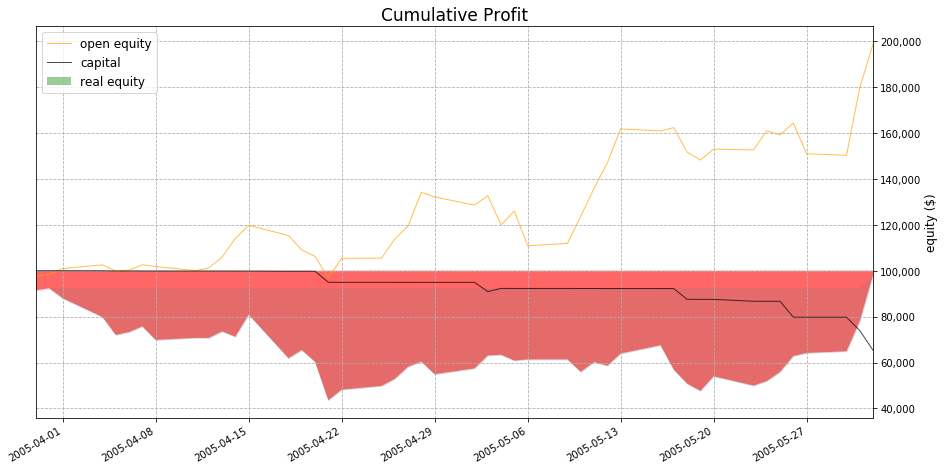

,투자금,최종자산,총손익,Bliss,ICAGR,MDD,손익비,승률,위험대비손익,평균손익,손익표준편차,보유기간,# trades
Total,"100,000","98,207",-1.79%,-0.199,-10.49%,52.80%,0.04,9.09%,-33.91%,"-3,096","2,503",22 days,63.8
Long,,,,,,,0.00,0.00%,-40.20%,"-4,000",nan,12 days,5.8
Short,,,,,,,0.04,10.00%,-33.28%,"-3,006","2,620",23 days,58.0


In [12]:
trader.summary(level=0)

In [40]:
trader.tradelog

,id,sector,symbol,name,position,entrydate,entryprice,stopprice,entrylot,exitdate,exitprice,exitlot,force,risk,profit,tick,strat
0,9,Metal,GC,Gold,Short,2005-04-18,626.5000,640.216430,6,2005-04-21,634.400000,6,False,11616.430126,-4740.0,-79.0,GC
1,13,Metal,GC,Gold,Long,2005-04-21,635.2000,627.188759,5,2005-05-03,627.188759,5,True,9950.571264,-4000.0,-80.0,GC
2,1,Equity,YM,Mini Dow,Short,2005-03-30,8810.0000,8739.590500,4,2005-05-04,8739.590500,4,True,10209.190772,1400.0,70.0,GC
3,12,Equity,FDAX,DAX,Short,2005-04-21,5301.8000,5464.909653,1,2005-05-18,5464.909653,1,True,6261.531380,-4075.0,-326.0,GC
4,15,Equity,FESX,DJ Euro Stoxx 50,Short,2005-04-26,2090.5000,2147.141685,1,2005-05-18,2147.141685,1,True,1637.545671,-570.0,-57.0,GC
5,10,Grain,ZC,Corn,Short,2005-04-18,480.7500,482.123627,12,2005-05-23,482.123627,12,True,11582.654230,-750.0,-5.0,GC
6,24,Metal,HG,Copper,Short,2005-05-17,1.4542,1.546874,3,2005-05-26,1.546874,3,True,11109.292681,-6937.5,-185.0,GC
7,21,Metal,SI,Silver,Short,2005-05-12,11.2060,11.592940,3,2005-05-31,11.592940,3,True,11201.781134,-5775.0,-77.0,GC
8,14,Equity,NKD,Nikkei 225 Dollar-based,Short,2005-04-21,12049.0000,12351.497684,3,2005-06-01,12351.497684,3,True,10935.793007,-4500.0,-60.0,GC
9,20,Petroleum,CL,Crude Oil (WTI),Short,2005-05-12,150.3500,152.511508,1,2005-06-01,152.511508,1,True,8805.552965,-2160.0,-216.0,GC


In [38]:
trader.summary(level=1)

,총손익(틱),평균손익(틱),표준편차(틱),위험대비손익,승률,매수평균(틱),매도평균(틱),Period(L),Period(S),# trades
Equity,-373,-93.25,166.58,-31.83%,25.00%,nan,-93.25,nan days,31 days,1.0
Grain,-5,-5.00,nan,-6.48%,0.00%,nan,-5.00,nan days,35 days,1.0
Metal,-421,-105.25,53.18,-48.75%,0.00%,-80.00,-113.67,12 days,10 days,1.3
Petroleum,-411,-205.50,14.85,-22.08%,0.00%,nan,-205.50,nan days,19 days,1.0


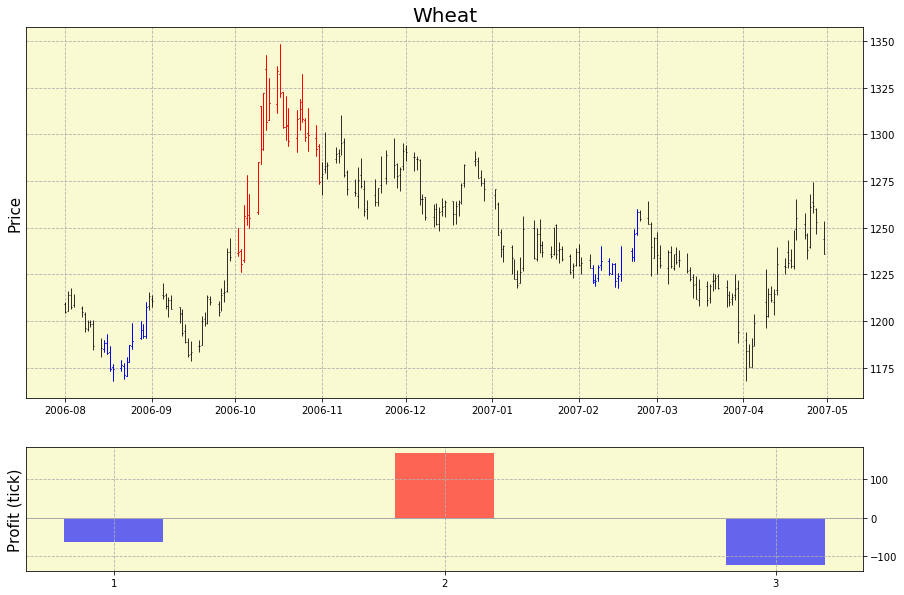

,id,sector,symbol,name,position,entrydate,entryprice,stopprice,entrylot,exitdate,exitprice,exitlot,force,risk,profit,tick,strat
0,163,Grain,ZW,Wheat,Short,2006-08-15,1184.75,1200.753699,2,2006-08-30,1200.753699,2,True,4972.383421,-1600.0,-64.0,GC
1,186,Grain,ZW,Wheat,Long,2006-10-02,1239.62,1281.660361,1,2006-10-31,1281.660361,1,True,2785.573684,2100.0,168.0,GC
2,218,Grain,ZW,Wheat,Short,2007-02-06,1226.25,1257.082235,1,2007-02-22,1257.082235,1,True,3175.679259,-1537.5,-123.0,GC


In [225]:
trader.report('ZW', start='2006-08', end='2007-04')

In [211]:
log = trader.tradelog

In [229]:
len(log)

292

In [ ]:
 lambda x: "±{:.2f}".format(abs(x))})'.format(1.234)